In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import History
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Dataset
dataset = load_dataset('app_reviews')
reviews = dataset['train']['review']
stars = dataset['train']['star']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/288065 [00:00<?, ? examples/s]

In [ ]:
# Tokenizer
tokenizer = Tokenizer(num_words=80000, oov_token='<00V>')
tokenizer.fit_on_texts(reviews)
reviews = tokenizer.texts_to_sequences(reviews)
reviews = pad_sequences(reviews, maxlen=300, truncating='post', padding='post')

In [ ]:
# Test & Training Set
train_review, test_review, train_star, test_star = (
    train_test_split(reviews, stars, test_size=0.75, random_state=42)
)

train_review = np.array(train_review)
test_review = np.array(test_review)
train_star = np.array(train_star)
test_star = np.array(test_star)

train_star -= 1
test_star -= 1

val_data = (test_review, test_star)

In [ ]:
# Modelo
model = Sequential()
history = History()

vocab = len(tokenizer.word_index)+1

model.add(Embedding(input_dim=vocab, output_dim=220, input_length=reviews.shape[1]))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mae'])
result = model.fit(train_review, train_star, epochs=12, batch_size=48, validation_data=val_data)

Epoch 1/12
1501/1501 [==============================] - 370s 245ms/step - loss: 1.0843 - accuracy: 0.6253 - mae: 2.8641 - val_loss: 0.9724 - val_accuracy: 0.6559 - val_mae: 2.8744
Epoch 2/12
1501/1501 [==============================] - 418s 278ms/step - loss: 0.9179 - accuracy: 0.6802 - mae: 2.8641 - val_loss: 0.9062 - val_accuracy: 0.6893 - val_mae: 2.8744
Epoch 3/12
1501/1501 [==============================] - 427s 285ms/step - loss: 0.8689 - accuracy: 0.6978 - mae: 2.8641 - val_loss: 0.8946 - val_accuracy: 0.6896 - val_mae: 2.8744
Epoch 4/12
1501/1501 [==============================] - 415s 277ms/step - loss: 0.8390 - accuracy: 0.7071 - mae: 2.8641 - val_loss: 0.8899 - val_accuracy: 0.6938 - val_mae: 2.8744
Epoch 5/12
1501/1501 [==============================] - 424s 282ms/step - loss: 0.8111 - accuracy: 0.7160 - mae: 2.8641 - val_loss: 0.9020 - val_accuracy: 0.6915 - val_mae: 2.8744
Epoch 6/12
1501/1501 [==============================] - 422s 281ms/step - loss: 0.7861 - accuracy: 0

In [ ]:
# Model - Info & Save
model.summary()
model.save('./model_trained_v1.keras')


# Log
with open('history_log.txt', 'w') as f:
    for key, value in result.history.items():
        f.write(f"{key}: {value}\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 220)          18668320  
                                                                 
 global_average_pooling1d (  (None, 220)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                14144     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 18682789 (71.27 MB)
Trainable params: 18682789 (71.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


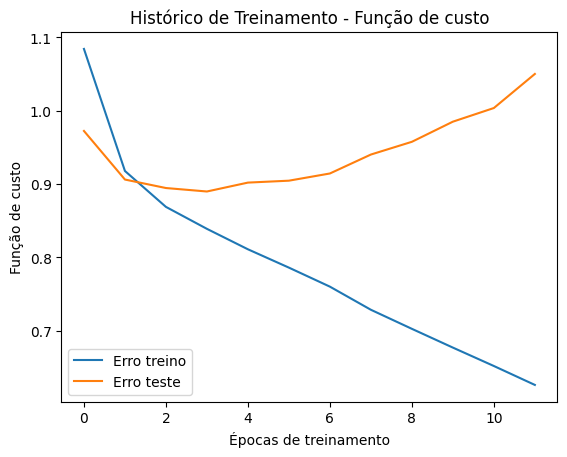

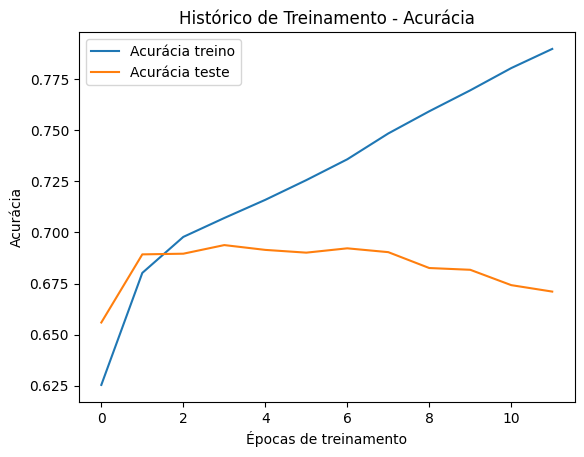

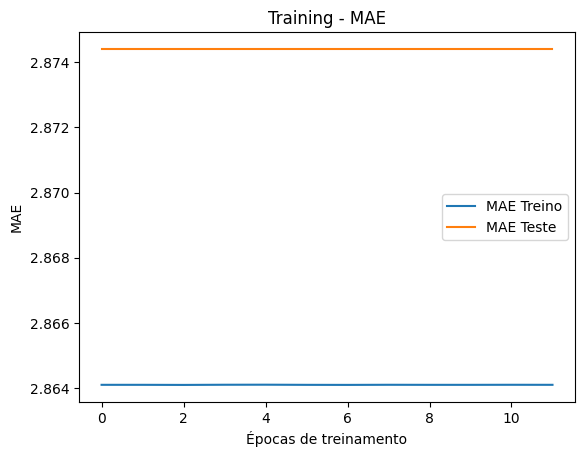

In [ ]:
# Matplotlib
plt.plot(result.history['loss'], label='Erro treino')
plt.plot(result.history['val_loss'], label='Erro teste')
plt.title('Histórico de Treinamento - Função de custo')
plt.ylabel('Função de custo')
plt.xlabel('Épocas de treinamento')
plt.legend()
plt.show()

plt.plot(result.history['accuracy'], label='Acurácia treino')
plt.plot(result.history['val_accuracy'], label='Acurácia teste')
plt.title('Histórico de Treinamento - Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas de treinamento')
plt.legend()
plt.show()

plt.plot(result.history['mae'], label='MAE Treino')
plt.plot(result.history['val_mae'], label='MAE Teste')
plt.title('Training - MAE')
plt.ylabel('MAE')
plt.xlabel('Épocas de treinamento')
plt.legend()
plt.show()

In [ ]:
# Frases de teste
test_phrases = [
    "This app is amazing, I love it!",  # 5 estrelas
    "The worst app ever, don't download it!",  # 1 estrela
    "This app is terrible, don't waste your time!",  # 1 estrela
    "Average app, nothing special.",  # 3 estrelas
    "It's okay, could be better.",  # 3 estrelas
    "Very useful, highly recommend it.",  # 5 estrelas
    "I don't like this app, very disappointing.",  # 2 estrelas
    "Amazing app! Couldn't live without it.",  # 5 estrelas
    "Needs improvement, but has potential.",  # 3 estrelas
    "The best app I've ever used!",  # 5 estrelas
    "An essential app for everyday use.",  # 5 estrelas
    "Not bad, but could use some updates.",  # 3 estrelas
    "Avoid this app at all costs, it's a scam!",  # 1 estrela
    "Incredible features, exceeded my expectations.",  # 5 estrelas
    "Unreliable app, crashes frequently.",  # 2 estrelas
    "Decent app, gets the job done.",  # 4 estrelas
    "Too many ads, very annoying.",  # 2 estrelas
    "Great app, easy to use interface.",  # 5 estrelas
    "Very disappointed, not what I expected.",  # 2 estrelas
    "Love this app, use it every day.",  # 5 estrelas
    "Could be better, needs more features.",  # 3 estrelas
    "Hate this app, waste of money.",  # 1 estrela
    "Exceptional performance, worth every penny."  # 5 estrelas
]



# Pré-processamento das frases de teste
test_sequences = tokenizer.texts_to_sequences(test_phrases)
test_sequences = pad_sequences(test_sequences, maxlen=300, truncating='post', padding='post')

# Fazendo previsões
predictions = model.predict(test_sequences)

# Interpretando as previsões
for i, phrase in enumerate(test_phrases):
    print(f"Phrase: {phrase}")
    print("Predictions:")
    for star in range(1, 6):
        print(f"   Star {star}: Probability = {predictions[i][star-1]*100:.2f}%")
    predicted_class = np.argmax(predictions[i]) + 1
    print(f"Predicted Class: Star {predicted_class}\n")

1/1 [==============================] - 0s 91ms/step
Phrase: This app is amazing, I love it!
Predictions:
   Star 1: Probability = 0.16%
   Star 2: Probability = 0.05%
   Star 3: Probability = 0.37%
   Star 4: Probability = 2.76%
   Star 5: Probability = 96.66%
Predicted Class: Star 5

Phrase: The worst app ever, don't download it!
Predictions:
   Star 1: Probability = 94.35%
   Star 2: Probability = 3.45%
   Star 3: Probability = 1.06%
   Star 4: Probability = 0.22%
   Star 5: Probability = 0.93%
Predicted Class: Star 1

Phrase: This app is terrible, don't waste your time!
Predictions:
   Star 1: Probability = 96.78%
   Star 2: Probability = 2.36%
   Star 3: Probability = 0.43%
   Star 4: Probability = 0.07%
   Star 5: Probability = 0.36%
Predicted Class: Star 1

Phrase: Average app, nothing special.
Predictions:
   Star 1: Probability = 6.83%
   Star 2: Probability = 10.01%
   Star 3: Probability = 43.77%
   Star 4: Probability = 30.23%
   Star 5: Probability = 9.17%
Predicted Class: 